# Airy stress functions method

The method of Airy stress functions is a method to find the stress distribution in an
elastic solid. The method uses a Airy stress function $\varphi$, a
[scalar potential](https://en.wikipedia.org/wiki/Potential_theory), and can be used
when:

- The problem is two dimensional.
- The body forces are derivable from a potential function $V$, i.e.,

$$\mathbf{b} = -\nabla V\, .$$

## Computation of stresses

The stresses are computed from the Airy functions as

\begin{align}
\sigma_{xx} &= \frac{\partial^2 \varphi}{\partial y^2}\\
\sigma_{yy} &= \frac{\partial^2 \varphi}{\partial x^2}\\
\sigma_{xy} &= -\frac{\partial^2 \varphi}{\partial x \partial y}\, ,
\end{align}

in Cartesian coordinates, and

\begin{align}
\sigma_{rr} &= \frac{1}{r}\frac{\partial \varphi}{\partial r} + \frac{1}{r^2}\frac{\partial^2 \varphi}{\partial r^2}\\
\sigma_{\theta\theta} &= \frac{\partial^2 \varphi}{\partial r^2}\\
\sigma_{r\theta} &= -\frac{\partial}{\partial r}\left(\frac{1}{r}\frac{\partial \varphi}{\partial \theta}\right)\, ,
\end{align}

in polar coordinates.




## Airy stress functions are biharmonic

In 2D, the compatibility equations and equilibrium imply

$$\nabla^2 \sigma_v = \frac{4}{1 + \kappa} \nabla^2 V\, ,$$

where $\sigma_v = \mathrm{Tr}\,(\sigma)$ is the volumetric component of the
stress tensor, and

$$\kappa =
\begin{cases}
3 - 4\nu\quad \text{plane strain}\\
\frac{3 - \nu}{1 + \nu}\quad \text{plane strain}
\end{cases}$$

Then, plugging the Airy stress function into this equation leads to

$$\nabla^2 \nabla^2 \varphi = -\frac{2(\kappa - 1)}{(1 + \kappa)}  \nabla^2 V$$

or, just

$$\nabla^4  \varphi = -\frac{2(\kappa - 1)}{(1 + \kappa)} \nabla^2 V$$

for short.

This means that the Airy stress functions are biharmonic, that is,
they satisfy the above equation.

In [1]:
from sympy import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

In [2]:
x, y, z, t = symbols('x y z t')
f, g, h = symbols('f g h', cls=Function)
init_printing()

In [3]:
%matplotlib notebook
plt.style.use("seaborn-notebook")
plt.rcParams["image.cmap"] = "RdYlBu_r"

The following cell contains the routines that we will use in the remaining
part of the notebook.

In [4]:
def poly_airy(x, y, order, coeff="c"):
    """Return a polynomial of a given order in x and y
    
    The coefficients of the polynomial are returned as a set in the
    variable ``c``.
    """
    num = (order**2 + 3*order + 2)/2
    c = symbols('%s0:%d' % (coeff, num))
    terms = [x**(order - k - j) * y**k
             for j in range(0, order - 1)
             for k in range(0, order + 1 - j)]
    phi = sum(c[k]*term for k, term in enumerate(terms))
    return phi, c


def airy_stress(phi, x, y):
    """Return stresses from the Airy stress function
    
    The coordinate system is Cartesian
    """
    return diff(phi, y, 2), diff(phi, x, 2), -diff(phi, y, 1, x, 1)


def conds2eqs(conds, var=(x, y)):
    """Turn the list of boundary conditions into equations to be solved
    
    In general, the final list can have repeated equations. Thus, we
    are removing those before returning it.
    """
    eqlist = [coef for cond in conds for coef in Poly(cond, var).coeffs()]
    return list(set(eqlist))


def plot_contours(x_coord, y_coord, field, fig=None, figsize=(7, 2), lines=True):
    """Plot the contours for a solution"""
    if fig is None:
        fig = plt.figure(figsize=figsize)
    f_max = max(np.max(field), -np.min(field))
    plt.contourf(x_coord, y_coord, field, vmin=-f_max, vmax=f_max)
    plt.colorbar()
    if lines:
        plt.contour(x_coord, y_coord, field, colors="k")
    plt.axis("image")
    return fig

## Solutions

### Cantilever beam with load at the end



A cantilever beam is a beam that is *anchored* at one end. In this case,
the beam has length $L$ and height $h$. The force $F$ is applied at
$x=L$.

In [5]:
L, h, F =  symbols("L h F")

To choose the Airy polynomial we need to fix the maximum power. This
seem to be arbitrary, but we can use the intuition that we have grasped
in the study of resistance of materials. Taking that into account,
we should have stresses with powers of two, then the Airy stress functions
should have at least powers of 4.

Picking 4 as maximum power will let us recover the desired
solution, but in general we don't know this beforehand, and we should
use a trial and error procedure. You could try with a maximum power of
10 for this example and it should still give you the same answer. 
It will take a while, though.

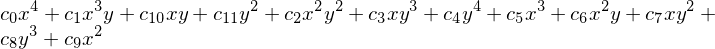

In [6]:
phi, c = poly_airy(x, y, 4)

phi

In [7]:
s11, s22, s12 = airy_stress(phi, x, y)
display(s11, s22, s12)

 The stress
boundary conditions for this problem are:

\begin{align}
&\sigma_{22}(x, y=h/2) = 0\\
&\sigma_{12}(x, y=h/2) = 0\\
&\sigma_{22}(x, y=-h/2) = 0\\
&\sigma_{12}(x, y=-h/2) = 0
\end{align}

Additionally, we have weak boundary conditions. That means, that
we are not satisfying a distribution of tractions point-wise but
in an average sense, namely

\begin{align}
&\int_{-h/2}^{h/2} \sigma_{11} \mathrm{d}y = 0\\
&\int_{-h/2}^{h/2} \sigma_{12} \mathrm{d}y = F\\
&\int_{-h/2}^{h/2} y\sigma_{11} \mathrm{d}y = 0\, .
\end{align}

With the weak conditions we are imposing that the system satisfy
global equilibrium

In [8]:
t1 = s22.subs(y, h/2)
t2 = s12.subs(y, h/2)
t3 = s22.subs(y, -h/2)
t4 = s12.subs(y, -h/2)
t5 = s11.subs(x, L)
t6 = s12.subs(x, L)

In [9]:
conds = [t1, t2, t3, t4,
         integrate(t5, (y, -h/2, h/2)),
         integrate(t6, (y, -h/2, h/2)) - F,
         integrate(y*t5, (y, -h/2, h/2)),
         diff(phi, x, 4) + diff(phi, y, 4) + 2*diff(phi, x, 2, y, 2)]

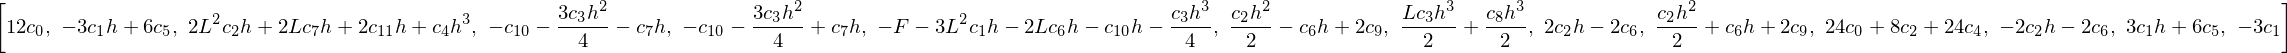

In [10]:
eqlist = conds2eqs(conds, (x, y))
eqlist

In [11]:
sol = solve(eqlist, c)

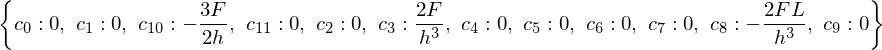

In [12]:
sol

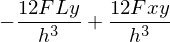

In [13]:
s11.subs(sol)

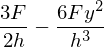

In [14]:
s12.subs(sol)

In [15]:
s22.subs(sol)

In [16]:
x_vec, y_vec = np.mgrid[0:10:100j, -1:1:100j]
s11_fun = lambdify((x, y, h, L, F), s11.subs(sol), "numpy")
s12_fun = lambdify((x, y, h, L, F), s12.subs(sol), "numpy")

In [17]:
s11_vec = s11_fun(x_vec, y_vec, 2, 10, 1)
plot_contours(x_vec, y_vec, s11_vec);

<IPython.core.display.Javascript object>

In [18]:
s12_vec = s12_fun(x_vec, y_vec, 2, 10, 1)
plot_contours(x_vec, y_vec, s12_vec, lines=False);

<IPython.core.display.Javascript object>

### Beam under pure bending

In [19]:
L, h, S =  symbols("L h S")

In [20]:
phi, c = poly_airy(x, y, 3)

phi

In [21]:
s11, s22, s12 = airy_stress(phi, x, y)

In [22]:
conds = [s22.subs(y, h/2),
         s12.subs(y, h/2),
         s22.subs(y, -h/2),
         s12.subs(y, -h/2),
         s11.subs(x, L/2) - S*y,
         s12.subs(x, L/2),
         s11.subs(x, -L/2) - S*y,
         s12.subs(x, -L/2)]

conds

In [23]:
eqlist = conds2eqs(conds)

eqlist

In [24]:
sol = solve(eqlist, c)

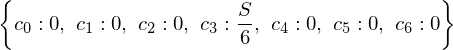

In [25]:
sol

In [26]:
s11.subs(sol)

In [27]:
s12.subs(sol)

In [28]:
s22.subs(sol)

In [29]:
s11_fun = lambdify((x, y, S), s11.subs(sol), "numpy")

In [30]:
s11_vec = s11_fun(x_vec, y_vec, 1)
plot_contours(x_vec, y_vec, s11_vec);

<IPython.core.display.Javascript object>

### Simply supported beam with uniform force

In [31]:
L, h, q =  symbols("L h q")

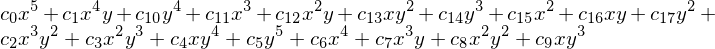

In [32]:
phi, d = poly_airy(x, y, 5)

phi

In [33]:
s11, s22, s12 = airy_stress(phi, x, y)
display(s11, s22, s12)

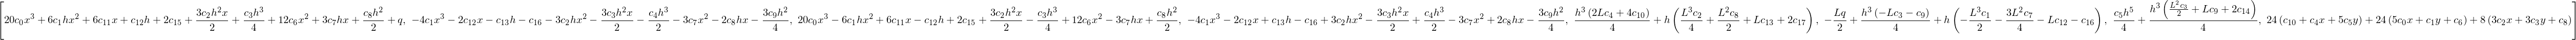

In [34]:
conds = [s22.subs(y, h/2) + q,
         s12.subs(y, h/2),
         s22.subs(y, -h/2),
         s12.subs(y, -h/2),
         integrate(s11.subs(x, L/2), (y,-h/2, h/2)),
         integrate(s12.subs(x, L/2), (y,-h/2, h/2)) - q*L/2,
         integrate(y*s11.subs(x, L/2), (y,-h/2, h/2)),
         diff(phi, x, 4) + diff(phi, y, 4) + 2*diff(phi, x, 2, y, 2)]
conds

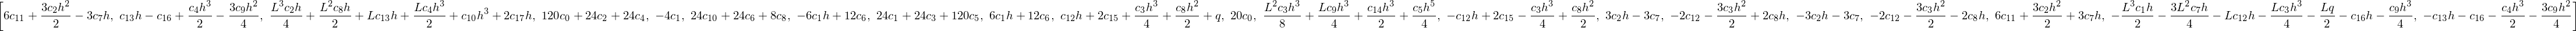

In [35]:
eqlist = conds2eqs(conds)

eqlist

In [36]:
sol = solve(eqlist, d)

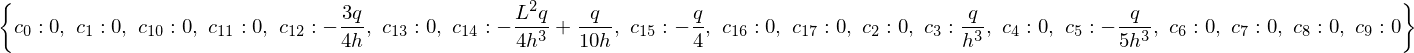

In [37]:
sol

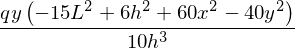

In [38]:
factor(s11.subs(sol))

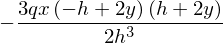

In [39]:
factor(s12.subs(sol))

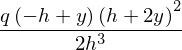

In [40]:
factor(s22.subs(sol))

In [41]:
x_vec, y_vec = np.mgrid[-5:5:100j, -1:1:100j]
s11_fun = lambdify((x, y, L, h, q), s11.subs(sol), "numpy")
s12_fun = lambdify((x, y, L, h, q), s12.subs(sol), "numpy")
s22_fun = lambdify((x, y, L, h, q), s22.subs(sol), "numpy")

In [42]:
s11_vec = s11_fun(x_vec, y_vec, 10, 2, 1)
plot_contours(x_vec, y_vec, s11_vec);

<IPython.core.display.Javascript object>

In [43]:
s12_vec = s12_fun(x_vec, y_vec, 10, 2, 1)
plot_contours(x_vec, y_vec, s12_vec);

<IPython.core.display.Javascript object>

In [44]:
s22_vec = s22_fun(x_vec, y_vec, 10, 2, 1)
plot_contours(x_vec, y_vec, s22_vec);

<IPython.core.display.Javascript object>

## Simply supported beam with triangular force

In [45]:
L, h, q =  symbols("L h q")

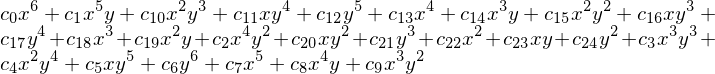

In [46]:
phi, d = poly_airy(x, y, 6)

phi

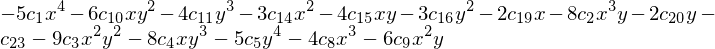

In [47]:
s11, s22, s12 = airy_stress(phi, x, y)
display(s11, s22, s12)

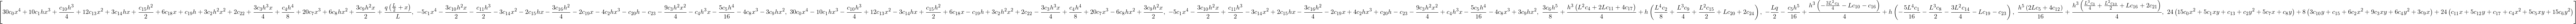

In [48]:
conds = [s22.subs(y, h/2) + (x + L/2)*q/L,
         s12.subs(y, h/2),
         s22.subs(y, -h/2),
         s12.subs(y, -h/2),
         integrate(s11.subs(x, L/2), (y,-h/2, h/2)),
         integrate(s12.subs(x, L/2), (y,-h/2, h/2)) - q*L/2,
         integrate(y*s11.subs(x, L/2), (y,-h/2, h/2)),
         diff(phi, x, 4) + diff(phi, y, 4) + 2*diff(phi, x, 2, y, 2)]
conds

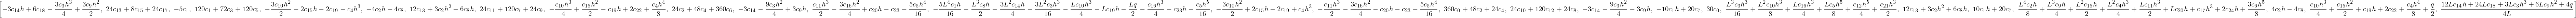

In [49]:
eqlist = conds2eqs(conds)

eqlist

In [50]:
sol = solve(eqlist, d)

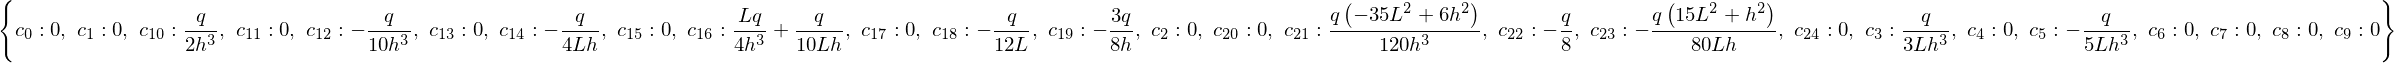

In [51]:
sol

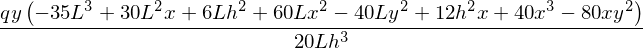

In [52]:
factor(s11.subs(sol))

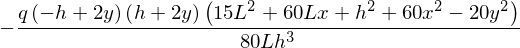

In [53]:
factor(s12.subs(sol))

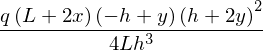

In [54]:
factor(s22.subs(sol))

In [55]:
x_vec, y_vec = np.mgrid[-5:5:100j, -1:1:100j]
s11_fun = lambdify((x, y, L, h, q), s11.subs(sol), "numpy")
s12_fun = lambdify((x, y, L, h, q), s12.subs(sol), "numpy")
s22_fun = lambdify((x, y, L, h, q), s22.subs(sol), "numpy")

In [56]:
s11_vec = s11_fun(x_vec, y_vec, 10, 2, 1)
plot_contours(x_vec, y_vec, s11_vec);

<IPython.core.display.Javascript object>

In [57]:
s12_vec = s12_fun(x_vec, y_vec, 10, 2, 1)
plot_contours(x_vec, y_vec, s12_vec);

<IPython.core.display.Javascript object>

In [58]:
s22_vec = s22_fun(x_vec, y_vec, 10, 2, 1)
plot_contours(x_vec, y_vec, s22_vec);

<IPython.core.display.Javascript object>

### Cantilever beam with variying thickness

In [59]:
L, h, q =  symbols("L h q")

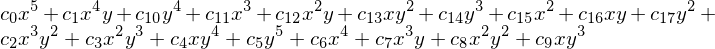

In [60]:
phi, d = poly_airy(x, y, 5)

phi

In [61]:
s11, s22, s12 = airy_stress(phi, x, y)
display(s11, s22, s12)

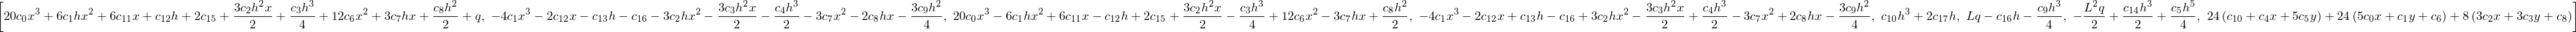

In [62]:
conds = [s22.subs(y, h/2) + q,
         s12.subs(y, h/2),
         s22.subs(y, -h/2),
         s12.subs(y, -h/2),
         integrate(s11.subs(x, 0), (y,-h/2, h/2)),
         integrate(s12.subs(x, 0), (y,-h/2, h/2)) + q*L,
         integrate(y*s11.subs(x, 0), (y,-h/2, h/2)) - q*L**2/2,
         diff(phi, x, 4) + diff(phi, y, 4) + 2*diff(phi, x, 2, y, 2)]
conds

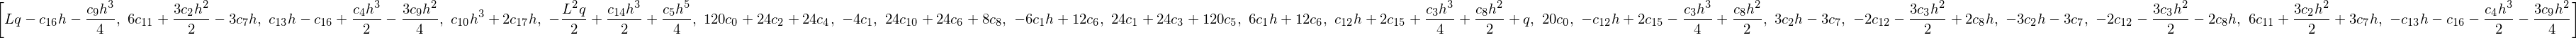

In [63]:
eqlist = conds2eqs(conds)
eqlist

In [64]:
sol = solve(eqlist, d)

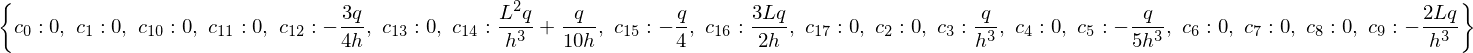

In [65]:
sol

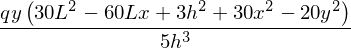

In [66]:
factor(s11.subs(sol))

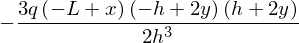

In [67]:
factor(s12.subs(sol))

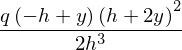

In [68]:
factor(s22.subs(sol))

In [69]:
x_vec, y_vec = np.mgrid[0:10:100j, -1:1:100j]
s11_fun = lambdify((x, y, L, h, q), s11.subs(sol), "numpy")
s12_fun = lambdify((x, y, L, h, q), s12.subs(sol), "numpy")
s22_fun = lambdify((x, y, L, h, q), s22.subs(sol), "numpy")

In [70]:
s11_vec = s11_fun(x_vec, y_vec, 10, 2, 1)
plot_contours(x_vec, y_vec, s11_vec);

<IPython.core.display.Javascript object>

In [71]:
s12_vec = s12_fun(x_vec, y_vec, 10, 2, 1)
plot_contours(x_vec, y_vec, s12_vec);

<IPython.core.display.Javascript object>

In [72]:
s22_vec = s22_fun(x_vec, y_vec, 10, 2, 1)
plot_contours(x_vec, y_vec, s22_vec);

<IPython.core.display.Javascript object>

### Cantilever beam with uniform force and triangular shape


We want to check that the stress function

$$\phi = C\left[r^2(\alpha - \theta) + \frac{1}{2}r^2 \sin(2\theta) - r^2\cos^2\theta \tan \alpha\right]$$

satisfy the boundary conditions for this problem.

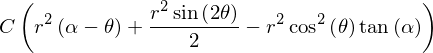

In [73]:
r, theta, C, alpha, q = symbols("r  theta C alpha q")
phi = C*(r**2*(alpha - theta) + r**2*sin(2*theta)/2 - r**2*cos(theta)**2*tan(alpha))
phi

In [74]:
Srr = simplify(1/r**2*diff(phi, theta, 2) + 1/r*diff(phi, r))
Srr

In [75]:
Stt = simplify(diff(phi, r, 2))
Stt

In [76]:
Srt = -simplify(diff(1/r*diff(phi, theta), r))
Srt

In the upper edge we have that

\begin{align}
  \sigma_{\theta\theta} &= -q\\
  \sigma_{r\theta} &= 0
\end{align}

and in the lower one

\begin{align}
  \sigma_{\theta\theta} &= 0\\
  \sigma_{r\theta} &= 0
\end{align}


The constant $C$ can be inferred from the first boundary condition, i.e.

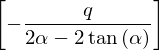

In [77]:
sol = solve(Stt.subs(theta, 0) + q, C)
sol

And the solution is then

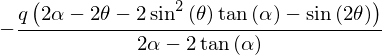

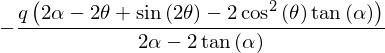

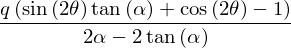

In [78]:
Srr2 = Srr.subs(C, sol[0])
Stt2 = Stt.subs(C, sol[0])
Srt2 = Srt.subs(C, sol[0])

display(Srr2)
display(Stt2)
display(Srt2)

And we need to check that the other boundary conditions are satisfied.

In [79]:
Srt.subs(theta, 0)

In [80]:
trigsimp(Stt.subs(theta, alpha))

SymPy does not detect that the other expression is zero,
but we can help rewriting the expression

In [81]:
simplify((Srt.subs(theta, alpha)).rewrite(sin))

If we want to write the solution in Cartesian coordinates we can change the frame
by

$$ [\sigma'] = [Q^T] [\sigma] [Q]$$

with

$$Q = \begin{bmatrix}
\cos(\theta) &\sin(\theta)\\
-\sin(\theta) &\cos(\theta)
\end{bmatrix}$$

In [82]:
Q = Matrix([
    [cos(theta), sin(theta)],
    [-sin(theta), cos(theta)]])
S_polar = Matrix([
    [Srr2, Srt2],
    [Srt2, Stt2]])

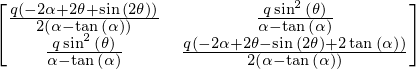

In [83]:
S_cart = simplify(Q.T *  S_polar * Q)
S_cart

In [84]:
angle = np.pi/10
t_vec, r_vec = np.mgrid[0:angle:100j, 0:5:100j]
x_vec = r_vec * np.cos(t_vec)
y_vec = r_vec * np.sin(t_vec)
s11_fun = lambdify((r, theta, alpha, q), S_cart[0, 0], "numpy")
s12_fun = lambdify((r, theta, alpha, q), S_cart[0, 1], "numpy")
s22_fun = lambdify((r, theta, alpha, q), S_cart[1, 1], "numpy")

<IPython.core.display.Javascript object>


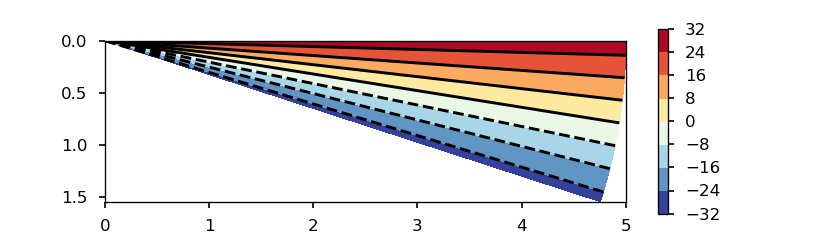

In [85]:
s11_vec = s11_fun(r_vec, t_vec, angle, 1)
plot_contours(x_vec, y_vec, s11_vec)
plt.gca().invert_yaxis();

<IPython.core.display.Javascript object>


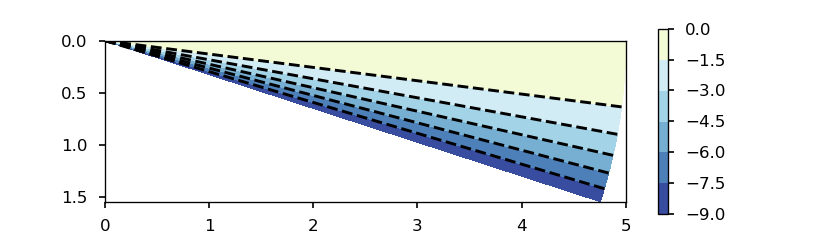

In [86]:
s12_vec = s12_fun(r_vec, t_vec, angle, 1)
plot_contours(x_vec, y_vec, s12_vec)
plt.gca().invert_yaxis();

<IPython.core.display.Javascript object>


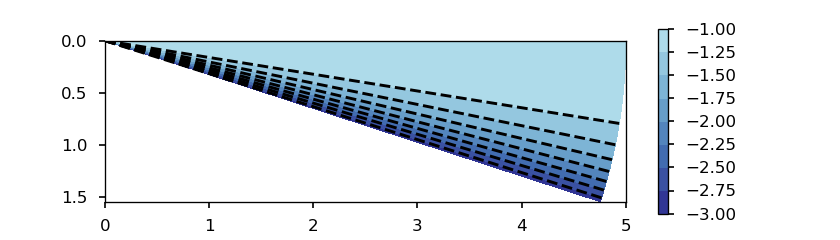

In [87]:
s22_vec = s22_fun(r_vec, t_vec, angle, 1)
plot_contours(x_vec, y_vec, s22_vec)
plt.gca().invert_yaxis();

The following cell changes the style of the notebook

In [88]:
from IPython.core.display import HTML
def css_styling():
    styles = open('./styles/custom_barba.css', 'r').read()
    return HTML(styles)
css_styling()